In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [34]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import sys
sys.path.append('/home/mei/nas/docker/thesis')
from dataloader.ts_reader import MultiModalDataset, collate_fn
from dataloader.pyg_reader import GraphDataset

from lstm_gnn_embedding import PatientOutcomeModelEmbedding
import pickle
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE
import numpy as np
from sklearn.cluster import KMeans


In [20]:
import gc
gc.collect()

torch.cuda.empty_cache()
torch.cuda.synchronize()

from torch.amp import GradScaler, autocast
scaler = GradScaler() 

In [18]:
flat_input_dim = 104
graph_input_dim = 104
ts_input_dim = 162
hidden_dim = 128

In [5]:
train_data_dir = "/home/mei/nas/docker/thesis/data/hdf/train"
val_data_dir = "/home/mei/nas/docker/thesis/data/hdf/val"
test_data_dir = "/home/mei/nas/docker/thesis/data/hdf/test"

config = {  
    "data_dir": "/home/mei/nas/docker/thesis/data/hdf",
    "graph_dir": "/home/mei/nas/docker/thesis/data/graphs",
    "mode": "k_closest",
    "k": 3         
}

In [6]:
# === LSTM + Flat Dataset ===
lstm_dataset_train = MultiModalDataset(train_data_dir)
lstm_dataset_val = MultiModalDataset(val_data_dir)
lstm_dataset_test = MultiModalDataset(test_data_dir)

lstm_loader_train = DataLoader(lstm_dataset_train , batch_size=32, shuffle=True, collate_fn=collate_fn)
lstm_loader_val = DataLoader(lstm_dataset_val , batch_size=32, shuffle=False, collate_fn=collate_fn)
lstm_loader_test = DataLoader(lstm_dataset_test , batch_size=32, shuffle=False, collate_fn=collate_fn)

# === Graph Dataset ===

graph_dataset = GraphDataset(config)


==> Loading precomputed graph from /home/mei/nas/docker/thesis/data/graphs/diagnosis_graph_k_closest_k3.pt
==> Loading flat features from /home/mei/nas/docker/thesis/data/hdf/final_flat.h5


In [12]:
def evaluate_model(model, lstm_loader, graph_dataset, criterion, device):
    model.eval()
    val_loss = 0.0
     
    all_labels = []
    all_predictions = []
     
    with torch.no_grad():
        for patient_ids, ts_data, flat_data, risk_data in lstm_loader:
            ts_data, flat_data, risk_data = ts_data.to(device), flat_data.to(device), risk_data.to(device)

            # ** get Graph Embeddings**
            patient_ids_tensor = torch.tensor([int(pid) for pid in patient_ids], dtype=torch.long, device=device)
            outputs,_= model(flat_data, graph_dataset.graph_data, patient_ids_tensor, ts_data)

            ts_mask = ts_data != -99
            ts_mask = ts_mask.any(dim=2)
            risk_mask = risk_data != -99
            combined_mask = (ts_mask & risk_mask).to(torch.bool)
            
            masked_outputs = outputs[combined_mask]
            masked_risk_data = risk_data[combined_mask]  

            loss = criterion(masked_outputs, masked_risk_data)
            val_loss += loss.item()
            
            all_labels.extend(masked_risk_data.cpu().numpy())
            all_predictions.extend(masked_outputs.cpu().numpy())
    
    val_mse = mean_squared_error(all_labels, all_predictions)

    return val_loss / len(lstm_loader),val_mse  

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   
model = PatientOutcomeModelEmbedding(flat_input_dim, graph_input_dim, ts_input_dim, hidden_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss() 

In [21]:
num_epochs=10

train_losses = []
val_losses = []
val_mse_losses = []

best_val_loss = float('inf')
best_model = '/home/mei/nas/docker/thesis/data/model_results'


for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for patient_ids, ts_data, flat_data, risk_data in lstm_loader_train:
        ts_data, flat_data, risk_data = ts_data.to(device), flat_data.to(device), risk_data.to(device)

        #convert patient_ids to tensor
        patient_ids_tensor = torch.tensor([int(pid) for pid in patient_ids], dtype=torch.long, device=device)

        # forward pass
        optimizer.zero_grad()
        with autocast(device_type='cuda', dtype=torch.float16):
            outputs,_ = model(flat_data, graph_dataset.graph_data, patient_ids_tensor, ts_data)

            ts_mask = ts_data != -99
            ts_mask = ts_mask.any(dim=2)
            risk_mask = risk_data != -99
            combined_mask = ts_mask & risk_mask

            masked_outputs = outputs[combined_mask]
            masked_risk_data = risk_data[combined_mask]

            loss = criterion(masked_outputs, masked_risk_data)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        torch.cuda.empty_cache()     
        
    train_loss /= len(lstm_loader_train)
    train_losses.append(train_loss)

    # calculate validation loss
    val_loss,val_mse = evaluate_model(model, lstm_loader_val, graph_dataset, criterion, device)
    val_losses.append(val_loss)
    val_mse_losses.append(val_mse)
             
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val MSE: {val_mse:.4f}")

    if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_path = os.path.join(best_model, 'best_model.pth')
            torch.save(model.state_dict(), save_path)
            print(f"Epoch {epoch+1}: Validation loss decreased to {val_loss:.4f}. Model saved to {save_path}.")

Epoch 1/10, Train Loss: 0.0129, Val Loss: 0.0195, Val MSE: 0.0194
Epoch 1: Validation loss decreased to 0.0195. Model saved to /home/mei/nas/docker/thesis/data/model_results/best_model.pth.
Epoch 2/10, Train Loss: 0.0113, Val Loss: 0.0178, Val MSE: 0.0178
Epoch 2: Validation loss decreased to 0.0178. Model saved to /home/mei/nas/docker/thesis/data/model_results/best_model.pth.
Epoch 3/10, Train Loss: 0.0108, Val Loss: 0.0181, Val MSE: 0.0181
Epoch 4/10, Train Loss: 0.0106, Val Loss: 0.0181, Val MSE: 0.0181
Epoch 5/10, Train Loss: 0.0099, Val Loss: 0.0184, Val MSE: 0.0185
Epoch 6/10, Train Loss: 0.0095, Val Loss: 0.0182, Val MSE: 0.0183
Epoch 7/10, Train Loss: 0.0091, Val Loss: 0.0199, Val MSE: 0.0200
Epoch 8/10, Train Loss: 0.0091, Val Loss: 0.0187, Val MSE: 0.0187
Epoch 9/10, Train Loss: 0.0092, Val Loss: 0.0196, Val MSE: 0.0196
Epoch 10/10, Train Loss: 0.0093, Val Loss: 0.0206, Val MSE: 0.0206


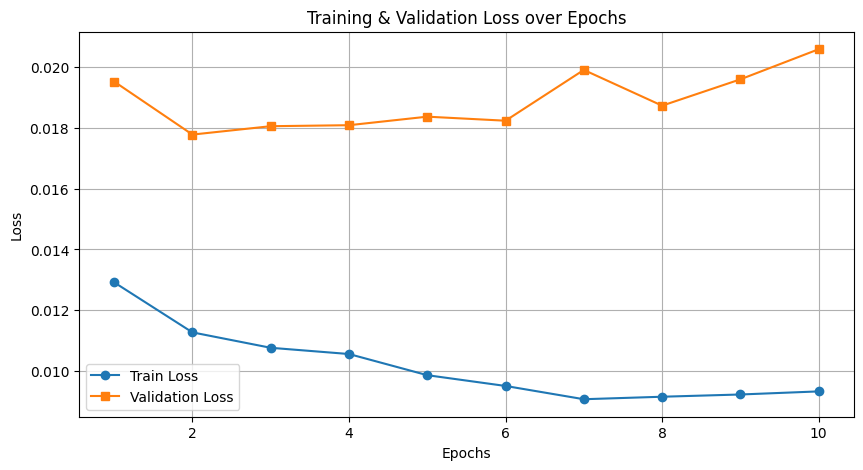

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss over Epochs")
plt.legend()
plt.grid()
plt.show()

## test model

In [32]:
best_model = '/home/mei/nas/docker/thesis/data/model_results/best_model.pth'
test_embedding = '/home/mei/nas/docker/thesis/data/test_embeddings/'
model.load_state_dict(torch.load(best_model,weights_only=True))

model.eval()
test_loss = 0.0

patient_embedding_dict = {} # used to store patient embeddings for each time step
patient_risk_dict = {} # used to store patient risk for each time step

with torch.no_grad():
    for batch_idx, (patient_ids, ts_data, flat_data, risk_data) in enumerate(lstm_loader_test):
        ts_data, flat_data, risk_data = ts_data.to(device), flat_data.to(device), risk_data.to(device)

        patient_ids_tensor = torch.tensor([int(pid) for pid in patient_ids], dtype=torch.long, device=device)

        outputs, embedding = model(flat_data, graph_dataset.graph_data, patient_ids_tensor, ts_data)

        ts_mask = ts_data != -99
        ts_mask = ts_mask.any(dim=2)
        risk_mask = risk_data != -99
        combined_mask = ts_mask & risk_mask

        masked_outputs = outputs[combined_mask]
        masked_risk_data = risk_data[combined_mask]

        loss = criterion(masked_outputs, masked_risk_data)
        test_loss += loss.item()
      
        outputs_np = outputs.detach().cpu().numpy()  # (batch_size, T)
        embeddings_np = embedding.detach().cpu().numpy()  # (batch_size, T, D_combined)
        patient_ids_np = patient_ids_tensor.detach().cpu().numpy()

        for i, pid in enumerate(patient_ids_np):
            patient_embedding_dict[pid] = embeddings_np[i]  # (T, D_combined)
            patient_risk_dict[pid] = outputs_np[i]  # (T,)
            
        

test_loss /= len(lstm_loader_test)
print(f'Test Loss: {test_loss:.4f}')

save_dir = '/home/mei/nas/docker/thesis/data/model_results' 
os.makedirs(save_dir, exist_ok=True)
torch.save(patient_embedding_dict, os.path.join(save_dir, 'test_patient_embeddings.pth'))
torch.save(patient_risk_dict, os.path.join(save_dir, 'test_patient_risks.pth'))

Test Loss: 0.0147


Cluster 0: Average risk = 0.3042
Cluster 1: Average risk = 0.3076
Cluster 2: Average risk = 0.0270
Cluster 3: Average risk = 0.3391
Cluster 4: Average risk = 0.3175


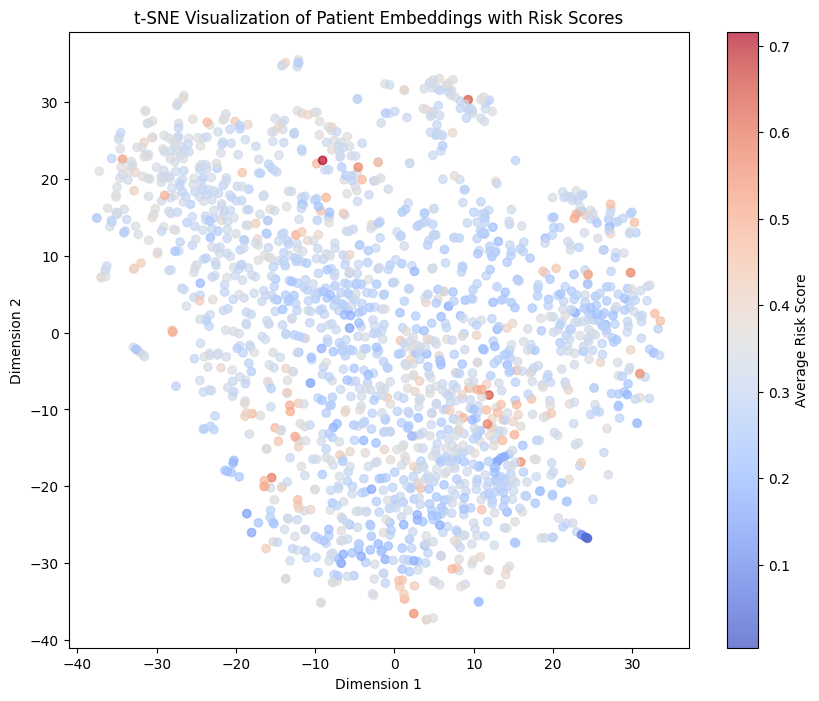

In [35]:
patient_ids = list(patient_embedding_dict.keys())
patient_avg_embeddings = np.array([np.mean(patient_embedding_dict[pid], axis=0) for pid in patient_ids])
patient_avg_risk = np.array([np.mean(patient_risk_dict[pid]) for pid in patient_ids])



num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(patient_avg_embeddings)
cluster_avg_risk = {}
for cluster in range(num_clusters):
    indices = np.where(cluster_labels == cluster)[0]
    cluster_avg_risk[cluster] = np.mean(patient_avg_risk[indices])
    print(f"Cluster {cluster}: Average risk = {cluster_avg_risk[cluster]:.4f}")
    
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(patient_avg_embeddings)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                      c=patient_avg_risk, cmap='coolwarm', alpha=0.7)
plt.colorbar(scatter, label='Average Risk Score')
plt.title('t-SNE Visualization of Patient Embeddings with Risk Scores')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [ ]:
batch_dir = '/home/mei/nas/docker/thesis/data/test_embeddings/batch_0'
embeddings_path = os.path.join(batch_dir, "embeddings.pth")
risk_path = os.path.join(batch_dir, "risk_scores.pth")

embeddings = torch.load(embeddings_path,weights_only= True)  # shape: (batch_size, T, D_combined)
risk_scores = torch.load(risk_path,weights_only= True)         # shape: (batch_size, T)

embeddings_np = embeddings.cpu().numpy()  # (batch_size, T, D_combined)
risk_np = risk_scores.cpu().numpy()         # (batch_size, T)

num_samples, T, D = embeddings_np.shape
embeddings_reshaped = embeddings_np.reshape(-1, D)  # shape: (num_samples * T, D)
risk_reshaped = risk_np.reshape(-1)                # shape: (num_samples * T,)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_reshaped)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=risk_reshaped, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Risk Score')
plt.title('t-SNE Visualization of Test Set Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')


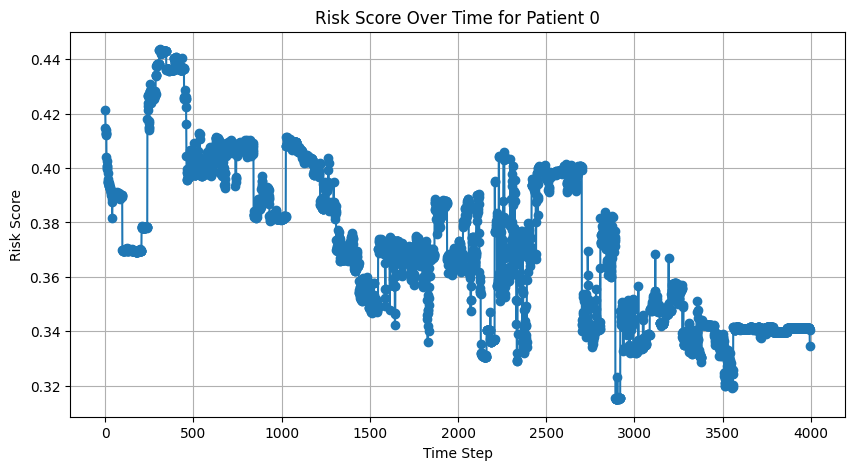

In [31]:
patient_risk = risk_np[0]  
T = len(patient_risk)
time_steps = range(T)

plt.figure(figsize=(10, 5))
plt.plot(time_steps, patient_risk, marker='o', linestyle='-')
plt.xlabel('Time Step')
plt.ylabel('Risk Score')
plt.title('Risk Score Over Time for Patient 0')
plt.grid(True)
plt.show()

In [ ]:
 
# patient_embedding_dict = {} # used to store patient embeddings for each time step
# patient_risk_dict = {} # used to store patient risk for each time step

    # if epoch == num_epochs-1:
    #     print(" Storing embeddings and risk scores from last epoch...")
    #     for patient_ids, ts_data, flat_data, risk_data in lstm_loader_train:
    #         ts_data, flat_data, risk_data = ts_data.to(device), flat_data.to(device), risk_data.to(device)
    #         patient_ids_tensor = torch.tensor([int(pid) for pid in patient_ids], dtype=torch.long, device=device)

    #         outputs, embeddings = model(flat_data, graph_dataset.graph_data, patient_ids_tensor, ts_data)

    #         outputs_np = outputs.detach().cpu().numpy()  # (batch_size, T)
    #         embeddings_np = embeddings.detach().cpu().numpy()  # (batch_size, T, D_combined)
    #         patient_ids_np = patient_ids_tensor.detach().cpu().numpy()

    #         for i, pid in enumerate(patient_ids_np):
    #             patient_embedding_dict[pid] = embeddings_np[i]  # (T, D_combined)
    #             patient_risk_dict[pid] = outputs_np[i]  # (T,)

In [ ]:

# save_dir = '/home/mei/nas/docker/thesis/data/model_results' 
# os.makedirs(save_dir, exist_ok=True)

# # save patient_embedding_dict
# embedding_path = os.path.join(save_dir, 'patient_embedding_dict.pkl')
# with open(embedding_path, 'wb') as f:
#     pickle.dump(patient_embedding_dict, f)

# # save patient_risk_dict
# risk_path = os.path.join(save_dir, 'patient_risk_dict.pkl')
# with open(risk_path, 'wb') as f:
#     pickle.dump(patient_risk_dict, f)


In [5]:

save_dir = '/home/mei/nas/docker/thesis/data/model_results' 

# load patient_embedding_dict
embedding_path = os.path.join(save_dir, 'patient_embedding_dict.pkl')
with open(embedding_path, 'rb') as f:
    patient_embedding_dict = pickle.load(f)

# load patient_risk_dict
risk_path = os.path.join(save_dir, 'patient_risk_dict.pkl')
with open(risk_path, 'rb') as f:
    patient_risk_dict = pickle.load(f)


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 假设embeddings是模型的嵌入向量，labels是对应的类别标签，risks是风险评分
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(embeddings)

# 创建数据框便于可视化
df = pd.DataFrame(tsne_results, columns=['Dim1', 'Dim2'])
df['label'] = labels
df['risk'] = risks

# 绘制t-SNE散点图
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='Dim1', y='Dim2',
    hue='label', size='risk',
    palette=sns.color_palette("hsv", len(set(labels))),
    sizes=(20, 200),
    data=df,
    legend="full",
    alpha=0.8
)
plt.title('t-SNE Visualization of Embeddings with Risk Scores')
plt.show()


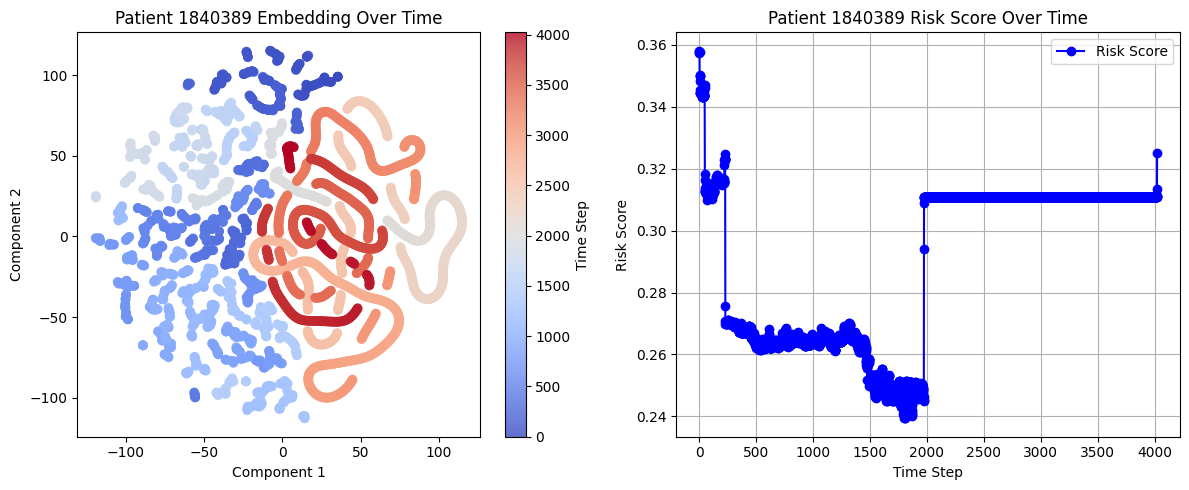

In [17]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


selected_patient_id = 1840389

# get risk and  embedding (T, D_combined)
selected_embedding = patient_embedding_dict[selected_patient_id]
selected_risk_score = patient_risk_dict[selected_patient_id]

# dimensionality reduction method
use_tsne = True  # set to False to use PCA
if use_tsne:
    reducer = TSNE(n_components=2, perplexity=5, random_state=42)
else:
    reducer = PCA(n_components=2)

# dimensionality reduction
embedding_2d = reducer.fit_transform(selected_embedding)  # (T, 2)

# plot risk and embedding over time
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# 1 Embedding
scatter = ax[0].scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=range(selected_embedding.shape[0]), cmap="coolwarm", alpha=0.8)
ax[0].set_title(f"Patient {selected_patient_id} Embedding Over Time")
ax[0].set_xlabel("Component 1")
ax[0].set_ylabel("Component 2")
fig.colorbar(scatter, ax=ax[0], label="Time Step")

# 2 Risk Score 
ax[1].plot(range(len(selected_risk_score)), selected_risk_score, marker='o', linestyle='-', color='b', label="Risk Score")
ax[1].set_xlabel("Time Step")
ax[1].set_ylabel("Risk Score")
ax[1].set_title(f"Patient {selected_patient_id} Risk Score Over Time")
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()


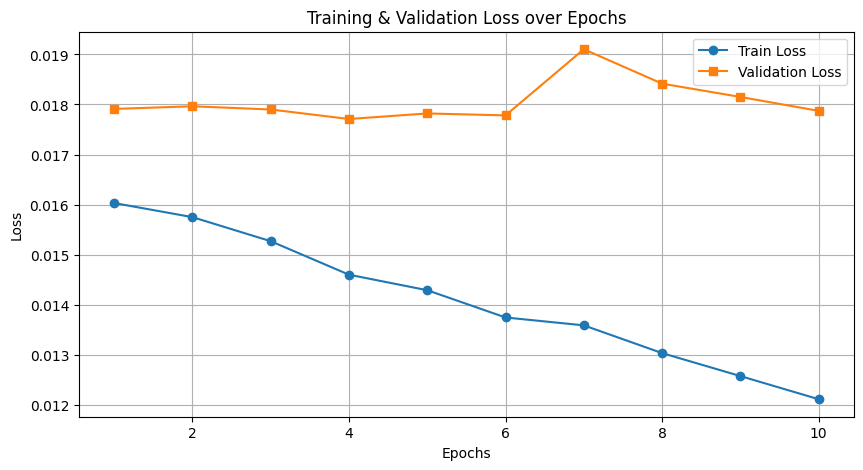

In [ ]:

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss over Epochs")
plt.legend()
plt.grid()
plt.show()